In [1]:
%matplotlib inline

import numpy as np
import skimage.io as io
import os
from PIL import Image
import tensorflow as tf


/Users/dmitry/workspace/tensorflow-sandbox/env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [54]:
images_dir = '../images'
image_files = ['{}/{}'.format(images_dir, x) for x in os.listdir(images_dir)]
# [os.path.exists(path)for path in image_files]

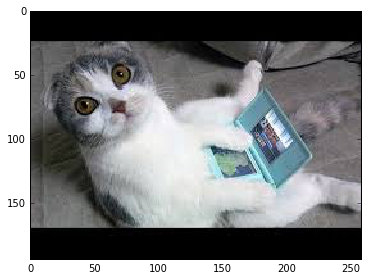

In [55]:
img_path = image_files[0]
cat_img = io.imread(img_path)
#cat_img.shape
io.imshow(cat_img)

In [63]:
# marshal as array of bytes
cat_string = cat_img.tostring()
reconstructed_cat_1d = np.fromstring(cat_string, dtype=np.uint8)
cat_img.shape

# reconstruct image (unmarshal)
reconstructed_cat_img = reconstructed_cat_1d.reshape(cat_img.shape)
np.allclose(cat_img, reconstructed_cat_img)
# reconstructed_cat_img.shape

True

In [91]:
### write images as tfrecords 

In [5]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [6]:
# save images to tfrecords file 

tfrecords_filename = '../data/pascal_voc_segmentation.tfrecords'

writer = tf.python_io.TFRecordWriter(tfrecords_filename)

for img_path in image_files:
    img = np.array(Image.open(img_path))
    height = img.shape[0]
    width = img.shape[1]
    img_raw = img.tostring()
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(height),
        'width': _int64_feature(width),
        'image_raw': _bytes_feature(img_raw)}))
    writer.write(example.SerializeToString())

writer.close()


In [92]:
### read images from tfrecords

In [7]:
# read tfrecords

read_images = []

record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)

for string_record in record_iterator:
    
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example.features.feature['width']
                                .int64_list
                                .value[0])
    
    img_string = (example.features.feature['image_raw']
                                  .bytes_list
                                  .value[0])
        
    img_1d = np.fromstring(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
        
    read_images.append(reconstructed_img)
    
read_images.__len__()

7

In [ ]:
### read from tfrecords in tf graph

In [6]:

IMAGE_HEIGHT = 250
IMAGE_WIDTH = 250

def read_and_decode(filename_queue):
    
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
        serialized_example,
        features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string)
        })

    image = tf.decode_raw(features['image_raw'], tf.uint8)    
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    
    image_shape = tf.pack([height, width, 3])    
    image = tf.reshape(image, image_shape)    
    image_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=tf.int32)
    
    resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)

    images = tf.train.shuffle_batch( [resized_image],
                                     batch_size=2,
                                     capacity=30,
                                     num_threads=1,
                                     min_after_dequeue=10)
    
    return images

batch 0
image shape: (250, 250, 3)


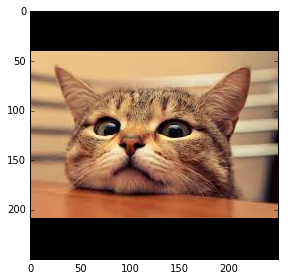

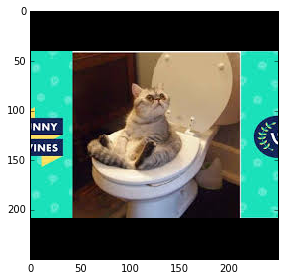

batch 1
image shape: (250, 250, 3)


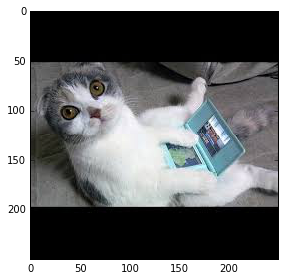

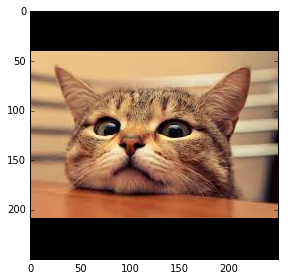

In [7]:
tfrecords_filename = '../data/pascal_voc_segmentation.tfrecords'

filename_queue = tf.train.string_input_producer([tfrecords_filename], num_epochs=None)

image = read_and_decode(filename_queue)

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

with tf.Session() as sess:
    init_op.run()

    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    for j in xrange(2):        

        print('batch {}'.format(j))

        # get x images (eq to batch num)
        img = sess.run(image)

        print 'image shape: {}'.format(img[0].shape)
        
        for i, _ in enumerate(img):            
            io.imshow(img[i])
            io.show()

    coord.request_stop()
    coord.join(threads)
 